# Zonal Statistics - Summarizing data within a boundary

## Setup

In [1]:
import ee
import eemont  # noqa: F401
import geemap
import geemap.colormaps as cm
import pandas as pd

### Authenticate Earth Engine

In [2]:
# ee.Authenticate()
ee.Initialize()

## Data and Area of interest

### Get boundaries

In [3]:
# Only available to Bison lab members
buffalo_expansion = ee.FeatureCollection("projects/bison-lab/assets/Buffalo_Expansion_polygons")

In [4]:
# Look at list of boundary names
geemap.ee_to_df(buffalo_expansion.select('Name'))

,Name
0,Brunot Cession 539
1,Fort Bridger Treaty
2,1906 ceded lands
3,WRIR
4,Riverton Reclamation Project
5,McLaughlin Agreement
6,WRIR w RRP
7,1906
8,1868 wilderness
9,WR Wilderness


In [5]:
# Select specific boundaries from list
parcels = buffalo_expansion.filter(ee.Filter.inList('Name', [
    "Shoshone Tribe",
    "Buffalo Initiative",
    "Hellyer Tribal Lease",
    "Adels Property",
    "Hoopengarner Property",
    "Hellyer Place"
    ]))

### Plot parcel boundaries

In [6]:
m = geemap.Map()
m.addLayer(parcels, {'color': 'red'}, 'Parcels')
m.centerObject(parcels, 14);
m

Map(center=[43.20344242266163, -108.80591236968854], controls=(WidgetControl(options=['position', 'transparent…

## Load data and compute zonal statistics
Here we use the NDVI product from MODIS (250m resolution)

In [7]:
# Select 1 image of NDVI for a random date
img = (
    ee.ImageCollection('MODIS/061/MOD13Q1')
    .closest('2018-01-01')
    .scaleAndOffset()
    .select('NDVI')
    .first()
)

In [8]:
# Plot image with parcels
m = geemap.Map()

vis_NDVI = {"min": 0, "max": 1, "palette": cm.palettes.ndvi}
layer_name = "NDVI"
m.addLayer(img, vis_NDVI, layer_name)
m.add_colorbar_branca(
    colors=vis_NDVI["palette"],
    vmin=vis_NDVI["min"],
    vmax=vis_NDVI["max"],
    layer_name=layer_name,
)

vis_parcels = {
    'color': '000000', 
    'width': 4,
    'lineType': 'solid',
    'fillColor': '00000000',
}
m.addLayer(parcels.style(**vis_parcels), {}, "Parcels")

m.centerObject(parcels, 14)
m

Map(center=[43.20344242266163, -108.80591236968854], controls=(WidgetControl(options=['position', 'transparent…

### Calculate the mean NDVI for each parcel

In [9]:
# Calc mean within each parcel
# NOTE: reduceRegions only works on Images, not featureCollections
stats = img.reduceRegions(parcels, 'mean', 250)

`stats` is a `FeatureCollection` so let's convert it to a Pandas DataFrame

In [10]:
df = geemap.ee_to_pandas(stats)
df = df[['Name', 'mean']]

In [11]:
df

,Name,mean
0,Hellyer Place,0.024002
1,Shoshone Tribe,0.049023
2,Buffalo Initiative,0.041372
3,Adels Property,0.008191
4,Hoopengarner Property,0.015093
5,Hellyer Tribal Lease,0.074127


## Time Series

In [12]:
# Load time series of NDVI
ds = (
    ee.ImageCollection('MODIS/061/MOD13Q1')
    .filterDate('2010-01-01', '2012-01-01')
    .scaleAndOffset()
    .select('NDVI')
)

#### Calc mean within each parcel

In [13]:
# NOTE: toBands() Converts the image collection to a single multi-band image, necessary to allow reduceRegions
stats = ds.toBands().reduceRegions(parcels, 'mean', 250) 

`stats` is a `FeatureCollection` so let's convert it to a `pd.DataFrame`

In [14]:
df = geemap.ee_to_df(stats)

In [15]:
# Drop un-needed columns
df = df.drop(columns=['visibility', 'descriptio', 'tessellate', 'extrude', 'icon', 'end', 'begin', 'timestamp', 'altitudeMo'])

# Set Names as index and transpose dataframe to have timeseries as index
df = df.set_index('Name').T

# Replace index of strings with datetimes from image collection
dates = pd.DatetimeIndex(pd.datetime.fromisoformat(x) for x in geemap.image_dates(ds).getInfo())
df.index = pd.DatetimeIndex(dates)

In [16]:
# Now we have a dataframe with NDVI for each parcel
df

Name,Hellyer Place,Shoshone Tribe,Buffalo Initiative,Adels Property,Hoopengarner Property,Hellyer Tribal Lease
2010-01-01,0.035865,0.040667,0.036962,0.023953,0.004696,0.057263
2010-01-17,0.023622,0.038985,0.041435,0.021588,0.014017,0.063573
2010-02-02,0.140057,0.135127,0.139333,0.132872,0.121275,0.133247
2010-02-18,-0.015240,-0.002719,-0.010255,-0.014188,-0.004800,0.022359
2010-03-06,0.185397,0.193577,0.204742,0.170296,0.147084,0.186935
2010-03-22,0.091151,0.059299,0.089103,0.185454,0.130471,0.199242
2010-04-07,0.216603,0.248938,0.291991,0.219043,0.143011,0.219616
2010-04-23,0.279322,0.330512,0.366217,0.298485,0.186292,0.259867
2010-05-09,0.365796,0.457215,0.461129,0.405492,0.248754,0.362310
2010-05-25,0.375738,0.484766,0.503777,0.412793,0.267786,0.405452


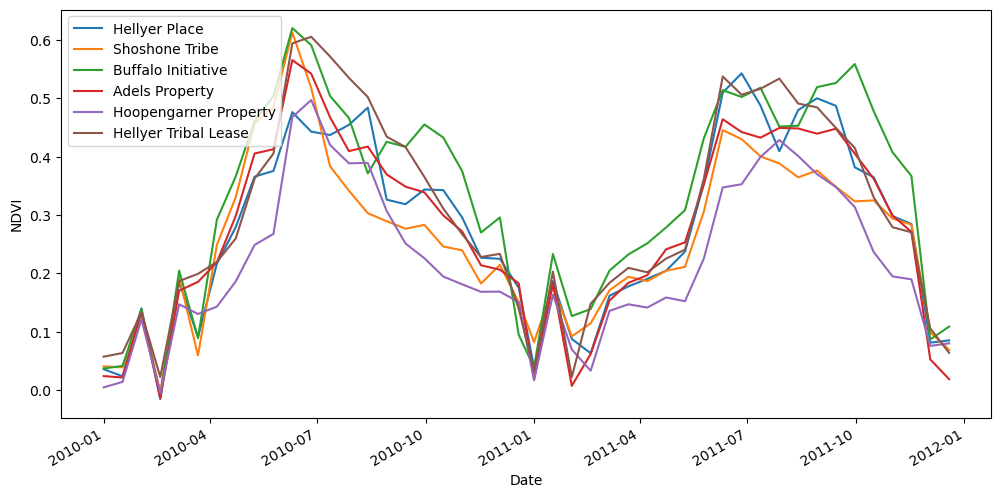

In [17]:
df.plot(figsize=(12, 6), xlabel='Date', ylabel='NDVI').legend(loc='upper left');